## Unfairness in Machine Learning models

In this project, we will explore unfairness in ML modesl using the diabetes dataset. 

### Fairlearn

Fairlearn is an open-source, community-driven project to help data scientists improve fairness of AI systems. It includes:

- A Python library for fairness assessment and improvement (fairness metrics, mitigation algorithms, plotting, etc.)

- Educational resources covering organizational and technical processes for unfairness mitigation (user guide, case studies, Jupyter notebooks, etc.)

The project was started in 2018 at Microsoft Research. In 2021 it adopted neutral governance structure and since then it is completely community-driven.

### Project goal 

This tutorial is built on the diabetes dataset to explore the racial disparities in how health care resources are allocated in the U.S. We built an automated system for recommending patients for high-risk care management programs. This based on the paper of Obermeyer et al., 2019. https://www.science.org/doi/10.1126/science.aax2342

In details, we will explore:

- Examine the dataset with the look for types of fairness.

- Train a classification model and assess its performance and fairness.

- Apply unfariness mitigation methods. 

### Load the dataset

We load the dataset from the desktop and explore the fairness problems in the dataset:
- Unbalanced demographic groups.
- Appropriateness of our choice of label (readmission within 30 days)
- Representativeness of different features for different groups
- Data collection method

In [2]:
# Import packages

from IPython import display
from datetime import date

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_curve
)

from sklearn import set_config

set_config(display="diagram")


In [3]:
#### An example of using graphviz to display the decision tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.datasets import load_iris
import graphviz

# Load iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Create and fit a decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Export the decision tree as a Graphviz dot file
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=iris.feature_names,  
                           class_names=iris.target_names,  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Visualize the decision tree using Graphviz
graph = graphviz.Source(dot_data)  
graph.render('decision_tree', format='png', cleanup=True)

'decision_tree.png'

In [4]:
# Load the data
df = pd.read_csv("diabetes_data.csv")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   discharge_disposition_id  101766 non-null  object
 4   admission_source_id       101766 non-null  object
 5   time_in_hospital          101766 non-null  int64 
 6   medical_specialty         101766 non-null  object
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  primary_diagnosis         101766 non-null  object
 11  number_diagnoses          101766 non-null  int64 
 12  max_glu_serum             5346 non-null    object
 13  A1Cresult                 17018 non-null   object
 14  insu

In [5]:
df.isna().sum()

race                            0
gender                          0
age                             0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
primary_diagnosis               0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
insulin                         0
change                          0
diabetesMed                     0
medicare                        0
medicaid                        0
had_emergency                   0
had_inpatient_days              0
had_outpatient_days             0
readmitted                      0
readmit_binary                  0
readmit_30_days                 0
dtype: int64

Exploring the datasest, we see that the dimension is 101766x25. Most columns are binary data. Except time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_diagnoses.

The description of the variables are:
- Demographic features: race, genger, age.
- Insurance information: medicare, medicaid.
- Emergency: admission_source_id
- Hospital visits in prior year: had_emergency, had_inpatient_days, had_outpatient_days
- Admitting physician's specialty: 
- description of the hospital visit: time_in_hospital, num_lab_procedures, num_procedures,
         num_medications, primary_diagnosis, number_diagnoses, max_glu_serum, A1Cresult, insulin_change, diabetesMed

- discharched to home or not: discharge_disposition_id
- readmission information: readmitted, readmit_binary, readmit_30_day

#### Categorical variables.

We will look at all the values of the categorical variables in the dataset.



In [6]:


numerical_values = {'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses'}

categorical_values = {}

for col in df.columns:
  if col not in numerical_values:
    # Extract unique categorical values and their counts
    categorical_values[col] = pd.Series(df[col].value_counts().index.to_list())

# Create a dataframe from the categorical values and fill the missing values with empty string
categorical_values_df = pd.DataFrame(categorical_values).fillna("")

categorical_values_df.T




,0,1,2,3,4,5
race,Caucasian,AfricanAmerican,Unknown,Hispanic,Other,Asian
gender,Female,Male,Unknown/Invalid,,,
age,Over 60 years,30-60 years,30 years or younger,,,
discharge_disposition_id,Discharged to Home,Other,,,,
admission_source_id,Emergency,Referral,Other,,,
medical_specialty,Missing,Other,InternalMedicine,Emergency/Trauma,Family/GeneralPractice,Cardiology
primary_diagnosis,Other,Respiratory Issues,Diabetes,Genitourinary Issues,Musculoskeletal Issues,
max_glu_serum,Norm,>200,>300,,,
A1Cresult,>8,Norm,>7,,,
insulin,No,Steady,Down,Up,,


In [7]:
# Show the values of all binary and categorical features
categorical_values = {}
for col in df:
  if col not in {'time_in_hospital', 'num_lab_procedures',
                 'num_procedures', 'num_medications', 'number_diagnoses'}:
    categorical_values[col] = pd.Series(df[col].value_counts().index.values)
categorical_values_df = pd.DataFrame(categorical_values).fillna('')
categorical_values_df.T

,0,1,2,3,4,5
race,Caucasian,AfricanAmerican,Unknown,Hispanic,Other,Asian
gender,Female,Male,Unknown/Invalid,,,
age,Over 60 years,30-60 years,30 years or younger,,,
discharge_disposition_id,Discharged to Home,Other,,,,
admission_source_id,Emergency,Referral,Other,,,
medical_specialty,Missing,Other,InternalMedicine,Emergency/Trauma,Family/GeneralPractice,Cardiology
primary_diagnosis,Other,Respiratory Issues,Diabetes,Genitourinary Issues,Musculoskeletal Issues,
max_glu_serum,Norm,>200,>300,,,
A1Cresult,>8,Norm,>7,,,
insulin,No,Steady,Down,Up,,


In [8]:
# Change all the categorical features to category data type

categorical_features = {
    "race",
    "gender",
    "age",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "primary_diagnosis",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "change",
    "diabetesMed",
    "readmitted"
}

for col in categorical_features:
    df[col] = df[col].astype("category")



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101766 non-null  category
 1   gender                    101766 non-null  category
 2   age                       101766 non-null  category
 3   discharge_disposition_id  101766 non-null  category
 4   admission_source_id       101766 non-null  category
 5   time_in_hospital          101766 non-null  int64   
 6   medical_specialty         101766 non-null  category
 7   num_lab_procedures        101766 non-null  int64   
 8   num_procedures            101766 non-null  int64   
 9   num_medications           101766 non-null  int64   
 10  primary_diagnosis         101766 non-null  category
 11  number_diagnoses          101766 non-null  int64   
 12  max_glu_serum             5346 non-null    category
 13  A1Cresult                 170

## Exploring groups

Group imbalances might cause unfairness. Small groups will lead to harder access for model training. Fewere training data points mean that our model fails to appropriately capture any data patterns specific to smaller groups, this leads to worse performances in these groups. 

### Race 

/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/2195472921.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, count+3, f'{values_percents[i]:.1f}%', ha='center', va='top')


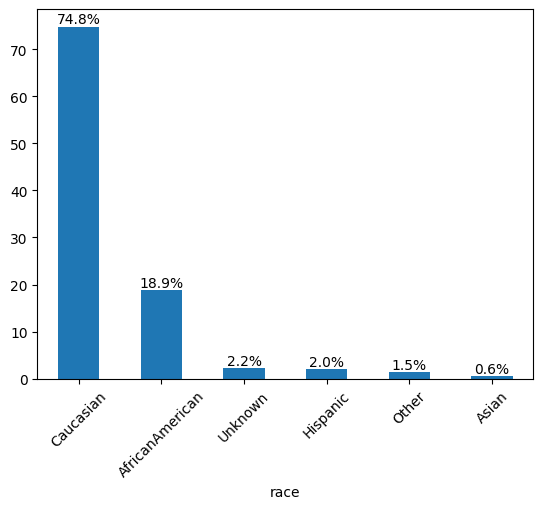

In [10]:
values_percents = df["race"].value_counts(normalize=True)*100
# Create bar plot
ax = values_percents.plot(kind='bar', rot=45)


# Annotate bars with counts and percentages
for i, count in enumerate(values_percents):
    ax.text(i, count+3, f'{values_percents[i]:.1f}%', ha='center', va='top')


As we can see, in our dataset the majority of patients are Caucasian (75%),the next group is African American which is 19%. The remaining 6% of the dataset is from other groups. Espcially, the Asian group has only 0.6% of patients. So, we can see the very imbalance propery within the race group. 
Now, we also look at the genders in the dataset. 


### Gender.

We also examine the dataset composition by gender: Female and Male.

gender
Female             53.758623
Male               46.238429
Unknown/Invalid     0.002948
Name: proportion, dtype: float64
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64


/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/2121351827.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, count+2, f'{values_percents[i]:.1f}%', ha='center', va='top')


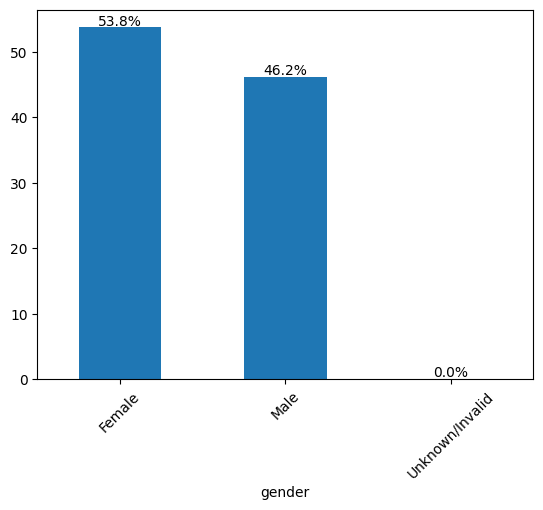

In [11]:
values_percents = df["gender"].value_counts(normalize=True)*100

print(values_percents)
print(df["gender"].value_counts())
# Create bar plot
ax = values_percents.plot(kind='bar', rot=45)


# Annotate bars with counts and percentages
for i, count in enumerate(values_percents):
    ax.text(i, count+2, f'{values_percents[i]:.1f}%', ha='center', va='top')


### Age

Now we will look at the age group in this dataset

/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/3654394997.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, count+2, f'{values_percents[i]:.1f}%', ha='center', va='top')


age
Over 60 years          68541
30-60 years            30716
30 years or younger     2509
Name: count, dtype: int64
age
Over 60 years          67.351571
30-60 years            30.182969
30 years or younger     2.465460
Name: proportion, dtype: float64
gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64


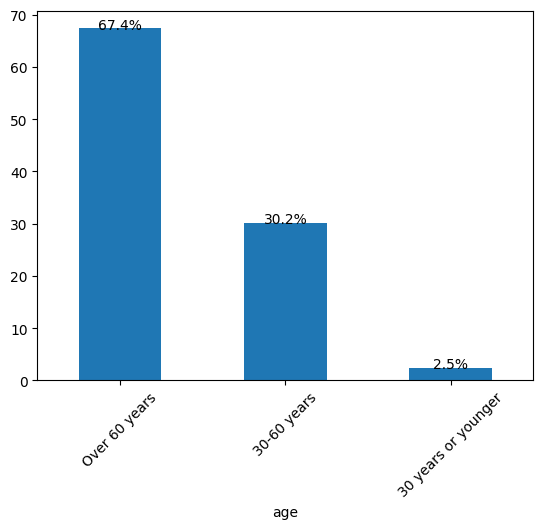

In [12]:
print(df["age"].value_counts())

values_percents = df["age"].value_counts(normalize=True)*100

print(values_percents)
print(df["gender"].value_counts())
# Create bar plot
ax = values_percents.plot(kind='bar', rot=45)


# Annotate bars with counts and percentages
for i, count in enumerate(values_percents):
    ax.text(i, count+2, f'{values_percents[i]:.1f}%', ha='center', va='top')


In our dataset, we see the two male and female groups are similar in size. However, a very small amount of patients (3) don't have gender in the record. We can delete the 3 rows. 

For the age group, we can see the imbalance data here. There are a small percentage of 30-years-or-younger vs 67.4% of over-60-years. We will keep all the data related for the age group for now but we will reconsider later. 

## How do we deal with smaller groups in the dataset?
To prevent imbalanced dataset, there are a few solutions in this step:
- Collect more data for the fewer groups.
- Merge the small groups together.
- Drop small groups.

Which approach will be chosen in this step will depend a lot on the domain knowledge such as which groups are at the greatest risk of harm. Dropping the small groups out of the study also cause the unfairness in terms of representational harm of erasure. Whatever approach is chosen for this step will have to be under careful mornitor. 

In our case, we will:
 - Merge the three smallest groups: Hispanic, Asian, Other.
 - Drop the 3 patients with unknown/invalid genders. 


In [13]:
# keep the original race as race_all, and merge Asian+Hispani+Other
df["race_all"] = df["race"]
df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"})

# drop the unknown/invalid gender
df = df.query("gender != 'Unknown/Invalid'" )

/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/326923707.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"})


## Examining the choice of label

Now we will explore whether the choice of label (readmission within 30 days) aligns with our goal for the project (identify patients that would benefit from the care management program). The goal of measurement modeling is to describe the relationship between what we care about and what we can measure. The thing that we care about is referred to as construct and what we can observe is referred to as measurement. In our case:
- construct = greatest benefit from the care management program
- measurement = readmission within 30 days (in the absence of such program)


Turning a concept into something measurable means making certain assumptions. In our case, we assume that the care management program benefits those patients most who would likely be readmitted to the hospital within 30 days if the program wasn't in place.

#### How can we check whether our assumptions apply?
In the terminology of measurement modeling, how do we establish construct validity? Following, Jacobs and Wallach, 2021,

- **Establishing Construct Validity**: This means showing that the measurements from our model are meaningful and useful. We do this by asking:
  - Does our method of measurement cover all important parts of what we're trying to measure?
  - Do the measurements make sense?
  - Do they match with other measurements of the same thing, or do they seem to be picking up on other things by mistake?
  - Are the measurements able to predict other things related to what we're measuring, even if those things aren't directly included in our method of measurement?
- **Focus on Predictive Validity**: This is one part of construct validity. It's about how well our measurements predict other related things, even if they're not part of what we're measuring directly.
  - These predictions don't have to be about the future or cause-and-effect. We just need to make sure they're not about the same thing we're measuring to check its validity.


### **Predictive validity**
We would like to show that our measurement readmit_30_days is correlated with patient characteristics that are related to our construct "benefiting from care management". One such characteristic is the general patient health, where we expect that patients that are less healthy are more likely to benefit from care management.

While our data does not contain full health records that would enable us to holistically measure general patient health, the data does contain two relevant features: had_emergency and had_inpatient_days, which indicate whether the patient spent any days in the emergency room or in the hospital (but non-emergency) in the preceding year.

#### To establish predictive validity, we would like to show that our measurement readmit_30_days is predictive of had-emergency and had-inpatient-day. 

First, let's check the rate at which the patients with different readmit_30_days labels were readmitted in the previous year:

/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/3866386310.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(y="had_emergency", x="readmit_30_days",


<Axes: xlabel='readmit_30_days', ylabel='had_emergency'>

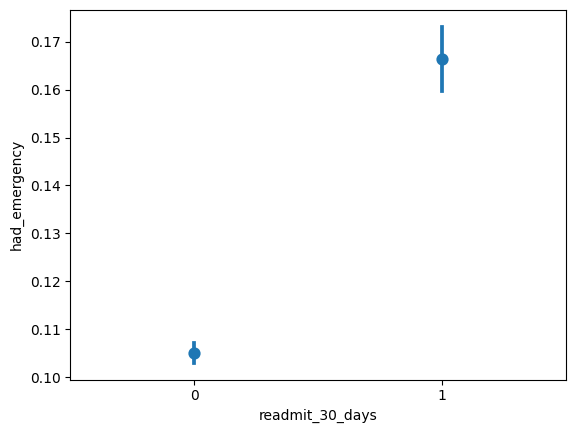

In [14]:
%matplotlib inline
sns.pointplot(y="had_emergency", x="readmit_30_days",
              data=df, errorbar=('ci', 95), join=False)

In [15]:
df["readmit_30_days"].value_counts()

df['had_emergency'].value_counts()

had_emergency
False    90380
True     11383
Name: count, dtype: int64

Now let's take a look whether the predictiveness is similar across different race groups. First, let's check how well readmit_30_days predicts had_emergency:

/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/2804919451.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(y="had_emergency", x="readmit_30_days", hue="race", data=df,


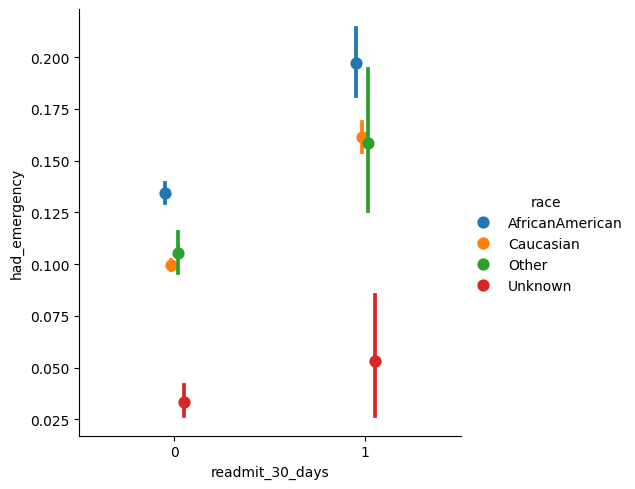

In [16]:

# Visualize predictiveness using a categorical pointplot
sns.catplot(y="had_emergency", x="readmit_30_days", hue="race", data=df,
            kind="point", errorbar=('ci', 95), dodge=True, join=False);

We can see that the African American group has the highest had-emergency but no readmit-30-days comparing to other groups. And we can see that, the readmit-30-days and had-emergency have highly positive correlation. Across all groups, the percentage of had-emergency also highly correlated to aeadmit-30-days. 

#### Now we are going to look at the relationship of had_inpatient_days and readmit_30_days.



/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/2504492857.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(y="had_inpatient_days", x="readmit_30_days", hue="race", data = df,


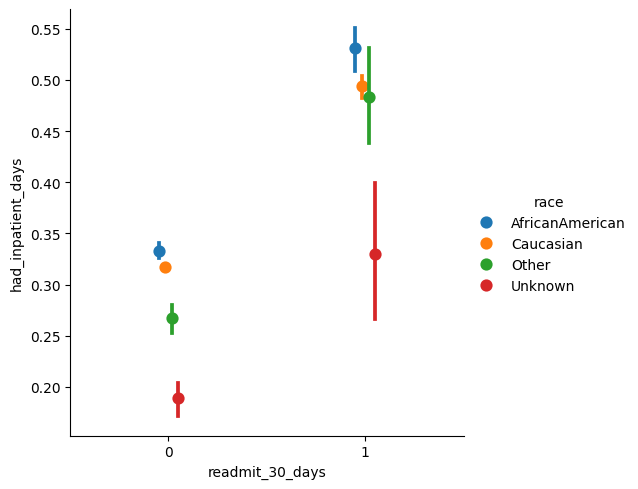

In [17]:

sns.catplot(y="had_inpatient_days", x="readmit_30_days", hue="race", data = df, 
            kind ="point", errorbar=('ci', 95), dodge=True, join=False)

We can see that the same pattern as for readmit_30_days and had_emergency can be seen in this relationship. This verify the predictive validity for our model. 

Consistenly, the group of patients with unknown race has lower readmit_30_days, lower emergency rate and lower inpatient visits comparing to other groups. This needs more explaination from domain expert to understand more about this systematical differences.

#### We only looked at predictive validity by race. To have more understanding about the dataset, we will also look at the relationship of readmit_30_days and had_emergency by gender and by age groups. 

/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/3685955814.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(y="had_inpatient_days", x="readmit_30_days", hue="gender", data = df,


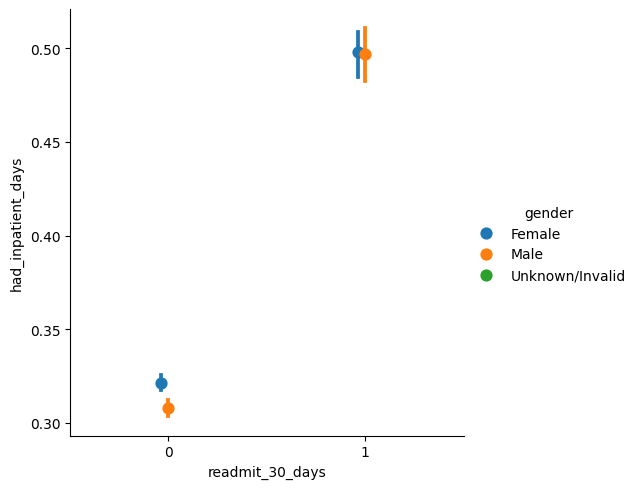

In [18]:

sns.catplot(y="had_inpatient_days", x="readmit_30_days", hue="gender", data = df, 
            kind ="point", errorbar=('ci', 95), dodge=True, join=False)

/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/2087711924.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.catplot(y="had_inpatient_days", x="readmit_30_days", hue="age", data = df,


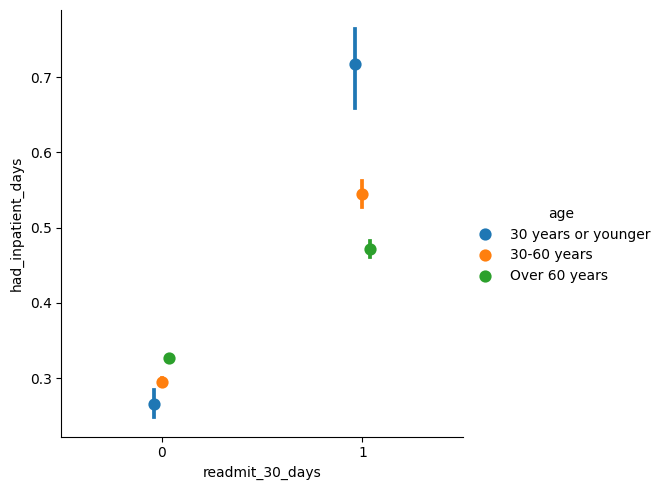

In [19]:

sns.catplot(y="had_inpatient_days", x="readmit_30_days", hue="age", data = df, 
            kind ="point", errorbar=('ci', 95), dodge=True, join=False)

Looking at the plots, we can see that there is no alarming problems related to age group or gender. The next step, we will explore the **Imbalanced label** problem.

### Imbalanced Labels.

Imblanced dataset is one problem that cause unfairness. So, we will check the frequency of the variable readmit_30_days in our dataset. The value 1 is for having readmit within 30 days. 

This is very important before doing data analysis as some algorithms don't work well with imbalanced dataset. The prediction in the smaller group is not uncertained. 



In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101765
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   race                      101763 non-null  category
 1   gender                    101763 non-null  category
 2   age                       101763 non-null  category
 3   discharge_disposition_id  101763 non-null  category
 4   admission_source_id       101763 non-null  category
 5   time_in_hospital          101763 non-null  int64   
 6   medical_specialty         101763 non-null  category
 7   num_lab_procedures        101763 non-null  int64   
 8   num_procedures            101763 non-null  int64   
 9   num_medications           101763 non-null  int64   
 10  primary_diagnosis         101763 non-null  category
 11  number_diagnoses          101763 non-null  int64   
 12  max_glu_serum             5346 non-null    category
 13  A1Cresult                 17018 no

<Axes: ylabel='proportion'>

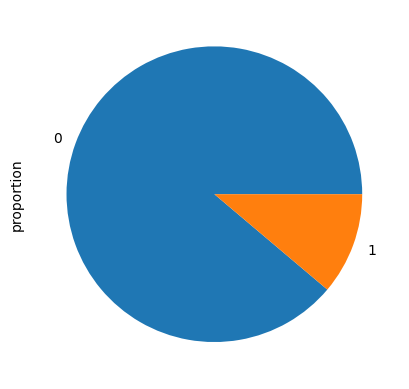

In [21]:
# Checking for the label

df.readmit_30_days.value_counts()

#df.readmit_30_days.value_counts().plot(kind='bar')

df.readmit_30_days.value_counts(normalize=True).plot(kind='pie')

According to the plot, we can see that our dataset is heaviliy skewed toward the group of patients who are not readdmitted to hospitals within 30 days, arouond 89% of the patients in the group.

This heavily skewed might lead to the uncertaincety in the estimation for the positive group. In another word, the FNR is much larger than FPR which means the model tends to predict negative (label=0) than positive (label=1). 

In our model, we target to balance the error rate (BER), which is the average of FPR and FNR. The value of this metric is robust to different frequencies of positives and negatives.

Now, wer are going to look at the distribution of the label among the race groups. It appears that the African American and Caucasian goup have similar percentages while the other two gruops have smaller proportions. However, the differences are not significant. 

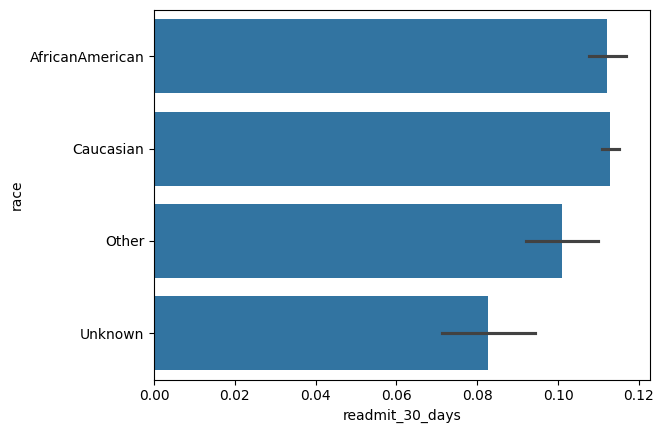

In [22]:
sns.barplot(x="readmit_30_days", y="race", data=df, errorbar=('ci', 95));

### Proxies for sensitive features

In the United States, Medicare and Medicaid are joint federal and state programs to help qualified individuals pay for healthcare expenses. Medicare is available to people over the age of 65 and younger individuals with severe illnesses. Medicaid is available to all individuals under the age of 65 whose adjusted gross income falls below the Federal Poverty Line.

Now, we will investigate which of the features are highly predictive of the sensitive feature race; such featrues are called proxies. 



/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/774864456.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(y="medicare", x="race", data=df, errorbar=('ci', 95), join=False);


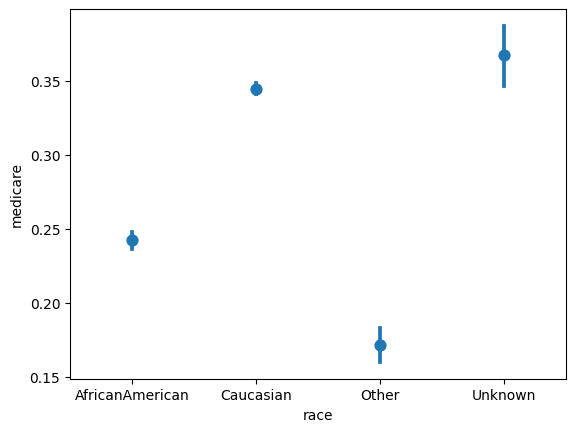

In [23]:
sns.pointplot(y="medicare", x="race", data=df, errorbar=('ci', 95), join=False);

/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/2006127722.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(y="medicare", x="age", data=df, errorbar=('ci', 95), join=False);


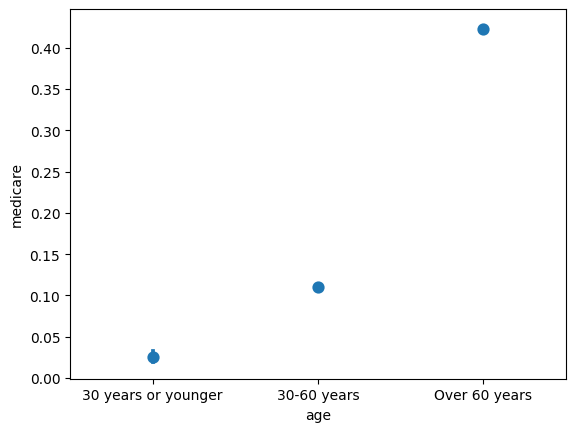

In [24]:
sns.pointplot(y="medicare", x="age", data=df, errorbar=('ci', 95), join=False);

/var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/ipykernel_1400/2264571003.py:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(y="medicare", x="gender", data=df, errorbar=('ci', 95), join=False);


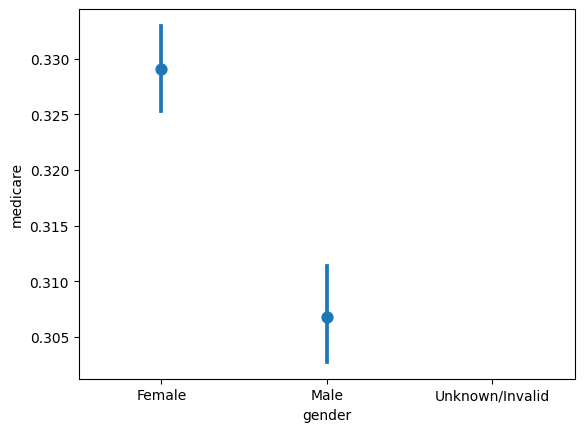

In [25]:
sns.pointplot(y="medicare", x="gender", data=df, errorbar=('ci', 95), join=False);

### Datasheets for datasets

The datasheets practice, introduced by Gebru et al. in 2018, suggests making a detailed document for each dataset. This document explains why the dataset was made, what it contains, how the data was collected, and how it should be used. The main goal is to help people who create datasets communicate better with those who use them. By being transparent and accountable about datasets, the practice aims to encourage responsible use of data in machine learning.


### **Composition**
- **Who created the dataset (e.g., which team) and on behalf of which entity?**

    The dataset was created by Strack et al. (2014): a team of researchers from a variety of disciplines, ranging from computer science to public health, from three institutions (Virginia Commonwealth University, University of Cordoba, and Polish Academy of Sciences).

- **What do the instances that comprise the dataset represent?**

    Each instance in this dataset represents a hospital admission for diabetic patient (diabetes was entered as a possible diagnosis for the patient) whose hospital stay lasted between one to fourteen days.

- **Is any information missing from individual instances?**

    The features Payer Code and Medical Specialty have 40,255 and 49,947 missing values, respectively. For Payer Code, these missing values are reflected in the category Unknown. For Medical Specialty, these missing values are reflecting in the category Missing.

    For our demographic features, we are missing the Gender information for three patients in the dataset. These three records were dropped from our final dataset. Regarding Race, the 2,271 missing values were recoded into the Unknown race category.

- **Does the dataset identify any subpopulations (e.g., by age, gender)?**

    Patients are identified by gender, age group, and race.

    For gender, patients are identified as Male, Female, or Unknown. There were only three instances where the patient gender is Unknown, so these records were removed from our dataset.

### **Preprocessing**
- Was any preprocessing/cleaning/labeling of the data done?

    For the race feature, the categories of Asian and Hispanic and Other were merged into the Other category. The age feature was bucketed into 30-year intervals (30 years and below, 30 to 60 years, and Over 60 years). The discharge_disposition_id was binarized into a boolean outcome on whether an patient was discharged to home.

    The full preprocessing code is provided in the file preprocess.py of the tutorial GitHub repository https://github.com/fairlearn/talks/tree/main/2021_scipy_tutorial

### **Uses**
- Has the dataset been used for any tasks already?

    This dataset has been used by Strack et al. (2014) to model the relationship between patient readmission and HbA1c measurement during admission, based on primary medical diagnosis.

    The dataset is publicly available through the UCI Machine Learning Repository and, as of May 2021, has received over 350,000 views.

## Training the model

Next, we build a classification model to predict our readmission within 30 days variable while mornitoring balanced accuracy. For this classification problem, what kind of model should we train: logistic regression model, random forest, neural networks? To mornitoring the question of fairness, intepretation is important, so first we will use Logistic regression for our problem. 

In [26]:

label = "readmit_30_days"
demographic = ["race", "gender"]
sensitive = ["race"]

Y, S = df.loc[:, label], df.loc[:, sensitive]
X = df.drop([
    "race",
    "race_all",
    "discharge_disposition_id",
    "readmitted",
    "readmit_binary",
    "readmit_30_days"], axis=1)

X = pd.get_dummies(X)

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101763 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                                    Non-Null Count   Dtype
---  ------                                    --------------   -----
 0   time_in_hospital                          101763 non-null  int64
 1   num_lab_procedures                        101763 non-null  int64
 2   num_procedures                            101763 non-null  int64
 3   num_medications                           101763 non-null  int64
 4   number_diagnoses                          101763 non-null  int64
 5   medicare                                  101763 non-null  bool 
 6   medicaid                                  101763 non-null  bool 
 7   had_emergency                             101763 non-null  bool 
 8   had_inpatient_days                        101763 non-null  bool 
 9   had_outpatient_days                       101763 non-null  bool 
 10  gender_Female                             101763 

In [34]:
# Split to train, test sets

X_train, X_test, Y_train, Y_test, S_train, S_test, df_train, df_test = train_test_split(
    X,
    Y,
    S,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=42
)

Our focus of model performance is balanced accuracy. With this focus, we split the data to train and test set based on the ratio of positive/negative labels. However, since the number of negative labels is much smaller than positive labels, this method will reduce the sample size. This might affect the model's accuracy. 

In [35]:

#Define the negative_ids, positive_ids and we will match the positive_id with negative_ids

neg_ids = Y_train[Y_train==0].index
pos_ids = Y_train[Y_train==1].index
balanced_ids = pos_ids.union(np.random.choice(a=neg_ids, size=len(pos_ids)))

X_train_bl = X_train.loc[balanced_ids, :]
Y_train_bl = Y_train.loc[balanced_ids]
S_train_bl = S_train.loc[balanced_ids, :]

## Exploring descriptive statistics of training and test data
We next evaluate descriptive statistics of the training dataset. 


Text(0.5, 1.0, 'Sensitive Attributes for Training Dataset')

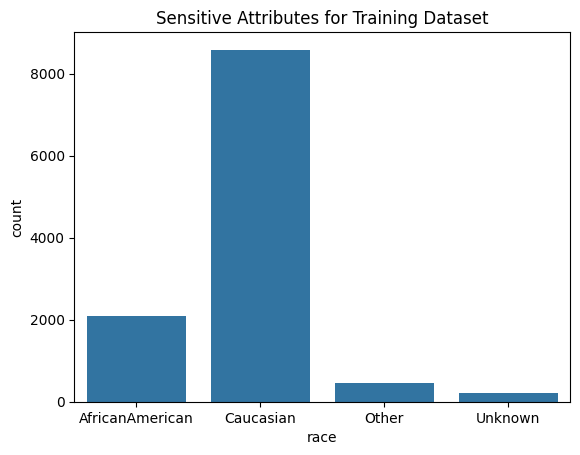

In [37]:
sns.countplot(x="race", data=S_train_bl)
plt.title("Sensitive Attributes for Training Dataset")


Text(0.5, 1.0, 'Target Label Histogram for Training Dataset')

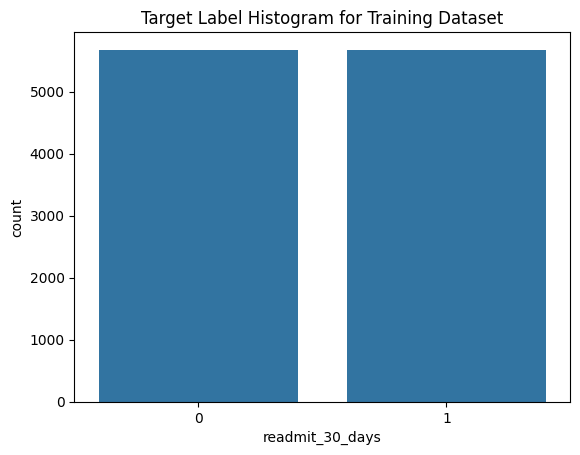

In [38]:
sns.countplot(x=Y_train_bl)
plt.title("Target Label Histogram for Training Dataset")


Text(0.5, 1.0, 'Sensitive Attributes for Testing Dataset')

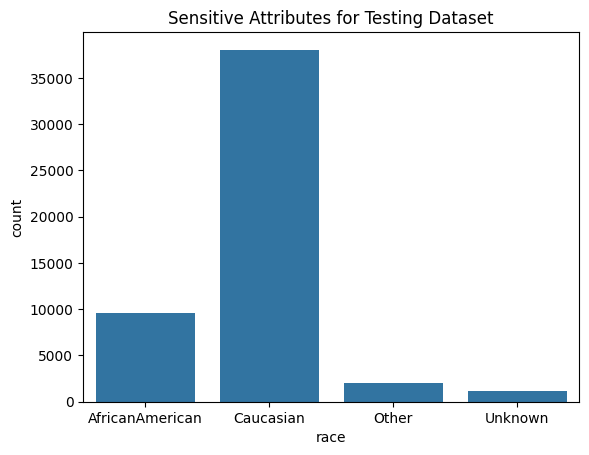

In [40]:
sns.countplot(x="race", data=S_test)
plt.title("Sensitive Attributes for Testing Dataset")


Text(0.5, 1.0, 'Target Label Histogram for Test Dataset')

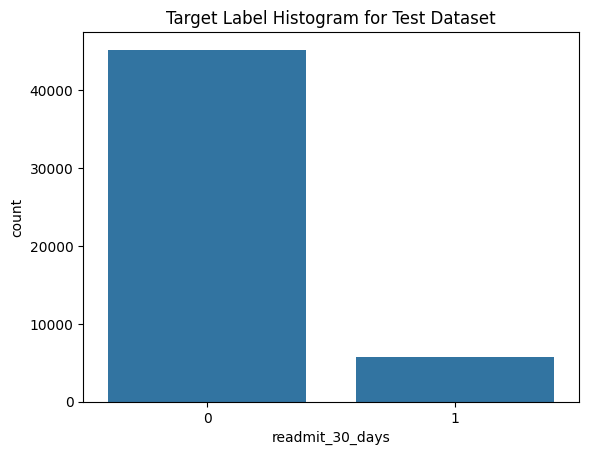

In [41]:
sns.countplot(x=Y_test)
plt.title("Target Label Histogram for Test Dataset")

## Train the model
We train a logistic regressiom model on the X_train_bl, Y_train_bl data.



We train a logistic regression model and save its predictions on test data for analysis.

unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])
unmitigated_pipeline.fit(X_train_bal, Y_train_bal)
Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])
Please rerun this cell to show the HTML repr or trust the notebook.
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)
Check model performance on test data.

# Plot ROC curve of probabilistic predictions
plot_roc_curve(unmitigated_pipeline, X_test, Y_test);

In [43]:
#Create a pipleline for our model

org_log_pipeline = Pipeline(steps=[
    ("stardardization", StandardScaler()),
    ('log', LogisticRegression(max_iter=1000))
])

org_log_pipeline.fit(X_train_bl, Y_train_bl)



Pipeline(steps=[('stardardization', StandardScaler()),
                ('log', LogisticRegression(max_iter=1000))])

In [44]:
Y_pred_proba =org_log_pipeline.predict_proba(X_test)[:,1]
Y_pred = org_log_pipeline.predict(X_test)

In [47]:
Y_pred_proba

array([0.40741777, 0.57231929, 0.42134366, ..., 0.41488239, 0.76513898,
       0.32140992])

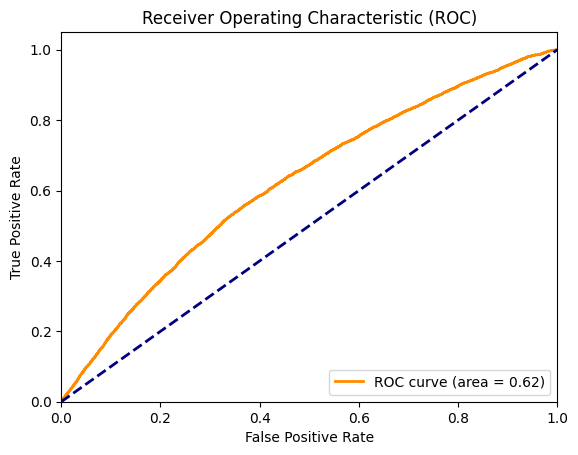

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [50]:
# Show balanced accuracy rate of the 0/1 predictions
balanced_accuracy_score(Y_test, Y_pred)

0.5940398831688181


A balanced accuracy score of 0.56 suggests that the model performs better than random guessing, but its adequacy depends on the baseline performance, class distribution, and domain-specific requirements of the problem.

### Inspect the coefficients of trained model
We inspect the coefficients of the fitted model to ensure their interpretability, which is subjective yet crucial for detecting errors and potential fairness issues, although we will comprehensively evaluate the model's fairness in the subsequent section; however, it's important to note that coefficients serve as a proxy for "feature importance," yet their interpretation may be misleading when features are highly correlated.



<Axes: >

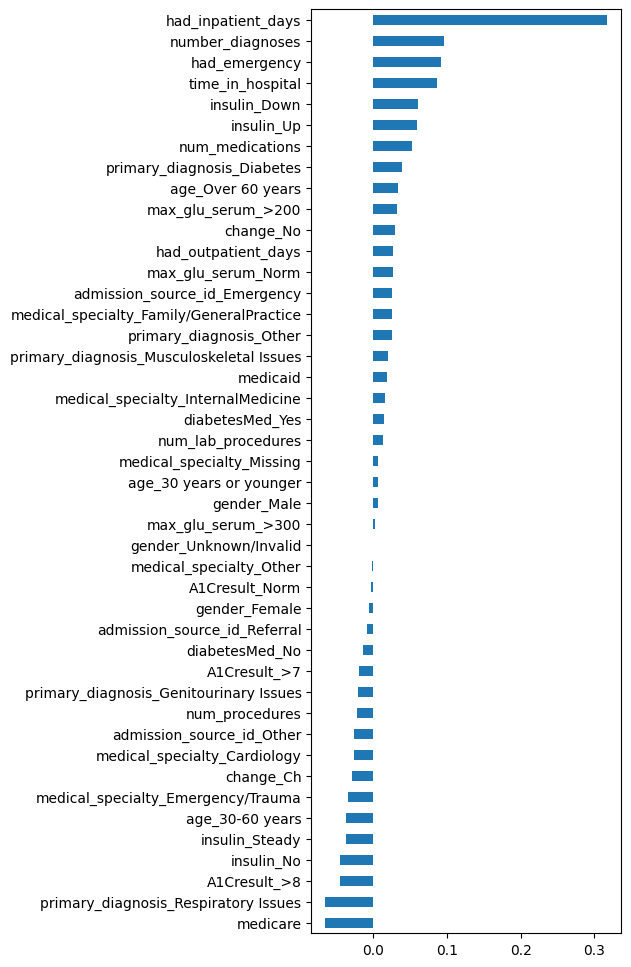

In [53]:
coef_values = pd.Series(data=org_log_pipeline.named_steps["log"].coef_[0], index=X.columns)
coef_values.sort_values().plot.barh(figsize = (4,12), legend=False)



## Fairness assessment

### Measuring fairness-related harms
In this part, we will evaluate fairness in the Logistic Regression model. So, the question is if there is any race group that negatively impacted by the model?

The steps will be:
- Identify harms.
- Identify the groups that might be hamrmed.
- Quantify harms.
- Compare quantified harms across the groups.

1. **Identify Harms**: In job screening, rejecting qualified candidates and high error rates in speech-to-text transcription indicate problems. In healthcare, not recommending beneficial care programs to eligible patients is an issue.

2. **Identify Affected Groups**: Consider demographic groups like gender and race, along with specific relevant groups such as regional dialects. Intersectionality, like Black women or Latinx nonbinary individuals, is also important.

3. **Quantify Harms**: Measure metrics like false negative rates for job screening and word error rates for transcription. In healthcare, assess false negative rates for missed care benefits and selection rates for program recommendation.

4. **Compare Across Groups**: Use metrics to compare errors across different groups, highlighting disparities and differences in performance. Focus on reporting the worst performance across all groups for a comprehensive view.

### Fairness assessment with MetricFrame
Fairlearn provides the data structure called *MetricFrame* to enable evaluation of disaggregated metrics. We will show how to use a MetricFrame object to assess the trained LogisticRegression classifier for potential fairness-related harms.

In [61]:
# In its simplest form MetricFrame takes four arguments:
#    metric_function with signature metric_function(y_true, y_pred)
#    y_true: array of labels
#    y_pred: array of predictions
#    sensitive_features: array of sensitive feature values


# Import other necessary metrics
from fairlearn.metrics import false_positive_rate, true_positive_rate, true_negative_rate, selection_rate, count

# Create MetricFrame object
mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# Access disaggregated metrics stored in a pandas Series
mf1.by_group


race
AfricanAmerican    0.424440
Caucasian          0.438678
Other              0.457143
Unknown            0.630000
Name: false_negative_rate, dtype: float64

In [62]:
# You can also evaluate multiple metrics by providing a dictionary

metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "false_positive_rate": false_positive_rate,
    "true_negative_rate": true_negative_rate,
    "true_positive_rate": true_positive_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are then stored in a pandas DataFrame:

metricframe_unmitigated.by_group

,selection_rate,false_negative_rate,false_positive_rate,true_negative_rate,true_positive_rate,balanced_accuracy
race,,,,,,
AfricanAmerican,0.407584,0.424440,0.386531,0.613469,0.575560,0.594514
Caucasian,0.396379,0.438678,0.375385,0.624615,0.561322,0.592968
Other,0.340611,0.457143,0.317666,0.682334,0.542857,0.612596
Unknown,0.245830,0.630000,0.233879,0.766121,0.370000,0.568061


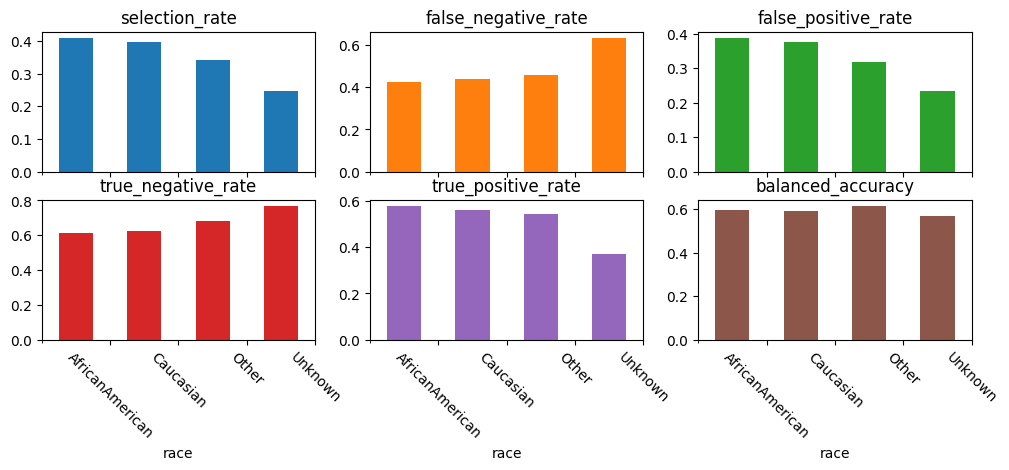

In [63]:
# You can also easily plot all of the metrics using DataFrame plotting capabilities

metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [2,3], figsize=(12, 4),
                      legend=False, rot=-45, position=1.5);

The "Unknown" group has a lower selection rate for the care program, coupled with the highest false negative rate, indicating that many who could benefit are overlooked. 

Disparities persist even without explicit race inclusion, likely due to insufficient representation or differences in feature distributions across groups, as seen in facial recognition systems.

## Mitigating fairness-related harms in ML models
Mitigation strategies for fairness issues, including those discussed, span various stages of the AI lifecycle, not just training. At the training stage, interventions can occur in preprocessing, training time, and postprocessing:

1. **Preprocessing**: Applying mitigation algorithms to transform input data before training. Strategies may aim to eliminate dependencies between input and sensitive features.

2. **Training Time**: Training models using optimization algorithms that incorporate fairness constraints to promote equitable outcomes.

3. **Postprocessing**: Transforming model outputs to address fairness concerns after training. For example, adjusting predicted probabilities based on group-specific thresholds.

We'll explore two algorithms: postprocessing and reductions. These are meta-algorithms that wrap around standard, fairness-unaware machine learning algorithms, offering versatility in practice.

### Postprocessing with ThresholdOptimizer

Postprocessing techniques are a class of unfairness-mitigation algorithms that take an already trained model and a dataset as an input and seek to fit a transformation function to model's outputs to satisfy some (group) fairness constraint(s). They might be the only feasible unfairness mitigation approach when developers cannot influence training of the model, due to practical reasons or due to security or privacy.

Here we use the **ThresholdOptimizer** algorithm from Fairlearn, which follows the approach of Hardt, Price, and Srebro (2016).

ThresholdOptimizer takes in an existing (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate thrceshold for each group in order to optimize some specified objective metric (such as balanced accuracy) subject to specified fairness constraints (such as false negative rate parity). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

The constraint false negative rate parity requires that all the groups have equal values of false negative rate.

To instatiate our ThresholdOptimizer, we pass in:

An existing estimator that we wish to threshold.
The fairness constraints we want to satisfy.

In [73]:
# Now we instantite ThresholdOptimizer with the logistic regression estimator with constrain is FNR
from fairlearn.postprocessing import ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
    estimator=org_log_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

# postprocess_est is the new adjusted model based on race. This will mitigate the model unfairness across race groups. 
postprocess_est.fit(X_train_bl, Y_train_bl, sensitive_features=S_train_bl)

# Record and evaluate the output of the trained ThresholdOptimizer on test data

Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=S_test)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=S_test
)

#We can now inspect how the metric values differ between the postprocessed model and the unmitigated model:

pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1)

# We next zoom in on differences between the largest and the smallest metric values:

pd.concat([metricframe_unmitigated.difference(),
           metricframe_postprocess.difference()],
          keys=['Unmitigated: difference', 'ThresholdOptimizer: difference'],
          axis=1).T

,selection_rate,false_negative_rate,false_positive_rate,true_negative_rate,true_positive_rate,balanced_accuracy
Unmitigated: difference,0.161755,0.205560,0.152652,0.152652,0.205560,0.044535
ThresholdOptimizer: difference,0.116159,0.045522,0.131496,0.131496,0.045522,0.070510


As we see, ThresholdOptimizer was able to substantially decrease the difference between the values of false negative rate.

In [74]:
# Now we instantite ThresholdOptimizer with the logistic regression estimator with constrain is TPR
from fairlearn.postprocessing import ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
    estimator=org_log_pipeline,
    constraints="true_positive_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

# postprocess_est is the new adjusted model based on race. This will mitigate the model unfairness across race groups. 
postprocess_est.fit(X_train_bl, Y_train_bl, sensitive_features=S_train_bl)

# Record and evaluate the output of the trained ThresholdOptimizer on test data

Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=S_test)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=S_test
)

#We can now inspect how the metric values differ between the postprocessed model and the unmitigated model:

pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1)

# We next zoom in on differences between the largest and the smallest metric values:

pd.concat([metricframe_unmitigated.difference(),
           metricframe_postprocess.difference()],
          keys=['Unmitigated: difference', 'ThresholdOptimizer: difference'],
          axis=1).T

,selection_rate,false_negative_rate,false_positive_rate,true_negative_rate,true_positive_rate,balanced_accuracy
Unmitigated: difference,0.161755,0.205560,0.152652,0.152652,0.205560,0.044535
ThresholdOptimizer: difference,0.108372,0.028488,0.119593,0.119593,0.028488,0.046939


## Reductions approach with ExponentiatedGradient

The ThresholdOpimizer, the unawared-fairness model is transformed to the new model with our fairness constraints based on race. One limitation of the ThresholdOptimizer is that it needs access to the sensitive features at deployment time. 

According to Agarwal et.al (2018) https://arxiv.org/abs/1803.02453, there is another approach to build a model that satisfies the fairness contraints, but does not need access to sensitive feature at deployment time. 

*Terminology "reductions" refers to another kind of a wrapper approach, which instead of wrapping an already trained model, wraps any standard classification or regression algorithm, such as LogisticRegression. In other words, an input to a reduction algorithm is an object that supports training on any provided (weighted) dataset. In addition, a reduction algorithm receives a data set that includes sensitive features. The goal, like with post-processing, is to optimize a performance metric (such as classification accuracy) subject to fairness constraints (such as an upper bound on differences between false negative rates).*

The main reduction algorithm in Fairlearn is ExponentialedGradient. It creates a sequence of reweighted datasets and retrains the wrapped model on each of them. The retraining process is guaranteed to find a model that satisfies the fairness contraints while optimizing the performance metric.


The model returned by ExponentiatedGradient consists of several inner models, returned by the wrapped estimator. At deployment time, ExponentiatedGradient randomizes among these models according to a specific probability weights.

To instantiate an ExponentiatedGradient model, we pass in two parameters:

- A base estimator (an object that supports training)
- Fairness constraints (an object of type Moment).

The constraints supported by ExponentiatedGradient are more general than those supported by ThresholdOptimizer. For example, rather than requiring that false negative rates be equal, it is possible to specify the maxium allowed difference or ratio between the largest and the smallest value.

In [75]:
from fairlearn.reductions import TruePositiveRateParity
from fairlearn.reductions import ExponentiatedGradient

expgrad_est = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    constraints=TruePositiveRateParity(difference_bound=0.02)
)

# Fit the exponentiated gradient model
expgrad_est.fit(X_train_bl, Y_train_bl, sensitive_features=S_train_bl)

/Users/hnguyen1/anaconda3/envs/dl/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/hnguyen1/anaconda3/envs/dl/lib/python3.

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x289c67050>,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=42),
                      nu=0.002302947989587983)


Similarly to ThresholdOptimizer the predictions of ExponentiatedGradient models are randomized. If we want to assure reproducible results, we can pass random_state to the predict function.

In [77]:
# Record and evaluate predictions on test data

Y_pred_reductions = expgrad_est.predict(X_test, random_state=42)
metricframe_reductions = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_reductions,
    sensitive_features=S_test
)
metricframe_reductions.by_group

# Evaluate the difference between the largest and smallest value of each metric
metricframe_reductions.difference()

selection_rate         0.067530
false_negative_rate    0.103694
false_positive_rate    0.069905
true_negative_rate     0.069905
true_positive_rate     0.103694
balanced_accuracy      0.042634
dtype: float64

Although there's a reduction in the difference in false negative rates compared to the unmitigated model, this decrease isn't as significant as what was achieved with the ThresholdOptimizer. It's important to note that the ThresholdOptimizer had the advantage of utilizing the sensitive feature (i.e., race) during deployment, which contributed to its more substantial improvement in fairness.

## Explore individual predictors

During the training process, the ExponentiatedGradient algorithm iteratively trains multiple inner models on a reweighted training dataset. The algorithm stores each of these predictors and then randomizes among them at deployment time.

In many applications, the randomization is undesirable, and also using multiple inner models can pose issues for interpretability. However, the inner models that ExponentiatedGradient relies on span a variety of fairness-accuracy trade-offs, and they could be considered for stand-alone deployment: addressing the randomization and interpretability issues, while possibly offering additional flexibility thanks to a variety of trade-offs.

In this section explore the performance of the individual predictors learned by the ExponentiatedGradient algorithm. First, note that since the base estimator was LogisticRegression all these predictors are different logistic regression models:

In [78]:
predictors = expgrad_est.predictors_
predictors

0     LogisticRegression(max_iter=1000, random_state...
1     LogisticRegression(max_iter=1000, random_state...
2     LogisticRegression(max_iter=1000, random_state...
3     LogisticRegression(max_iter=1000, random_state...
4     LogisticRegression(max_iter=1000, random_state...
5     LogisticRegression(max_iter=1000, random_state...
6     LogisticRegression(max_iter=1000, random_state...
7     LogisticRegression(max_iter=1000, random_state...
8     LogisticRegression(max_iter=1000, random_state...
9     LogisticRegression(max_iter=1000, random_state...
10    LogisticRegression(max_iter=1000, random_state...
11    LogisticRegression(max_iter=1000, random_state...
12    LogisticRegression(max_iter=1000, random_state...
dtype: object

In this section, we will explore how changing the base model for the ExponentiatedGradient affects the overall performance of the classifier.

We will instatiate a new ExponentiatedGradient classifier with a base HistGradientBoostingClassifer estimator. We will use the same difference_bound as above.

    1.) First, let's create our new ExponentiatedGradient instance in the cells below and fit it to the training data.

    2.) Now, let's compute the performance of the ExponentiatedGradient model and compare it with the performance of ExponentiatedGradient model with logistic regression as base 
    
    3.) Next, calculate the balanced error rate and false negative rate difference of each of the inner models learned by this new ExponentiatedGradient classifier.

In [82]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Create ExponentiatedGradient instance here
expgrad_exercise = ExponentiatedGradient(
    estimator=HistGradientBoostingClassifier(),
    constraints=TruePositiveRateParity(difference_bound=0.02)
)
# Fit the new instance to the balanced training dataset
expgrad_exercise.fit(X_train_bl, Y_train_bl, sensitive_features=S_train_bl)

# Save the predictions and report the disagregated metrics
# of the exponantiated gradient model
Y_expgrad_exercise = expgrad_exercise.predict(X_test)
mf_expgrad_exercise = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_expgrad_exercise,
    sensitive_features=S_test
)
mf_expgrad_exercise.by_group

/Users/hnguyen1/anaconda3/envs/dl/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/hnguyen1/anaconda3/envs/dl/lib/python3.

,selection_rate,false_negative_rate,false_positive_rate,true_negative_rate,true_positive_rate,balanced_accuracy
race,,,,,,
AfricanAmerican,0.445195,0.403918,0.426283,0.573717,0.596082,0.584899
Caucasian,0.455291,0.395159,0.436256,0.563744,0.604841,0.584292
Other,0.409025,0.385714,0.385737,0.614263,0.614286,0.614274
Unknown,0.369622,0.480000,0.355149,0.644851,0.520000,0.582425


In [83]:
# Compare with the disaggregated metric values of the
# exponentiated gradient model based on logistic regression
metricframe_reductions.by_group

,selection_rate,false_negative_rate,false_positive_rate,true_negative_rate,true_positive_rate,balanced_accuracy
race,,,,,,
AfricanAmerican,0.419844,0.426306,0.400561,0.599439,0.573694,0.586566
Caucasian,0.424153,0.441238,0.407020,0.592980,0.558762,0.575871
Other,0.356623,0.471429,0.337115,0.662885,0.528571,0.595728
Unknown,0.373134,0.530000,0.363811,0.636189,0.470000,0.553094


In [85]:
# Save the inner predictors of the new model
predictors_exercise = expgrad_exercise.predictors_
predictors_exercise

0     HistGradientBoostingClassifier()
1     HistGradientBoostingClassifier()
2     HistGradientBoostingClassifier()
3     HistGradientBoostingClassifier()
4     HistGradientBoostingClassifier()
5     HistGradientBoostingClassifier()
6     HistGradientBoostingClassifier()
7     HistGradientBoostingClassifier()
8     HistGradientBoostingClassifier()
9     HistGradientBoostingClassifier()
10    HistGradientBoostingClassifier()
11    HistGradientBoostingClassifier()
12    HistGradientBoostingClassifier()
13    HistGradientBoostingClassifier()
14    HistGradientBoostingClassifier()
15    HistGradientBoostingClassifier()
16    HistGradientBoostingClassifier()
17    HistGradientBoostingClassifier()
18    HistGradientBoostingClassifier()
19    HistGradientBoostingClassifier()
dtype: object

## Comparing performance of different techniques

Now we have covered two different class of techniques for mitigating the fairness-related harms we found in our fairness-unaware model.

 In this section, we will compare the performance of the models we trained above across our key metrics.

**Model performance - by group**

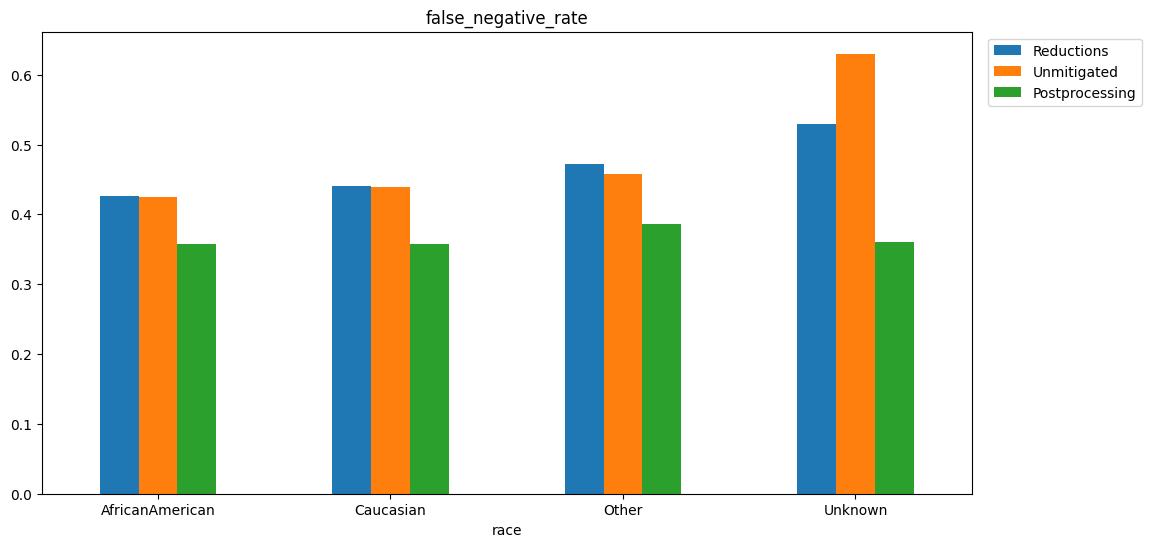

In [87]:
def plot_technique_comparison(mf_dict, metric):
  """
  Plots a specified metric for a given dictionary of MetricFrames.
  """
  mf_dict = {k:v.by_group[metric] for (k,v) in mf_dict.items()}
  comparison_df = pd.DataFrame.from_dict(mf_dict)
  comparison_df.plot.bar(figsize=(12, 6), legend=False)
  plt.title(metric)
  plt.xticks(rotation=0, ha='center');
  plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')
  
  
test_dict = {
    "Reductions": metricframe_reductions,
    "Unmitigated": metricframe_unmitigated,
    "Postprocessing": metricframe_postprocess
}


plot_technique_comparison(test_dict, "false_negative_rate")

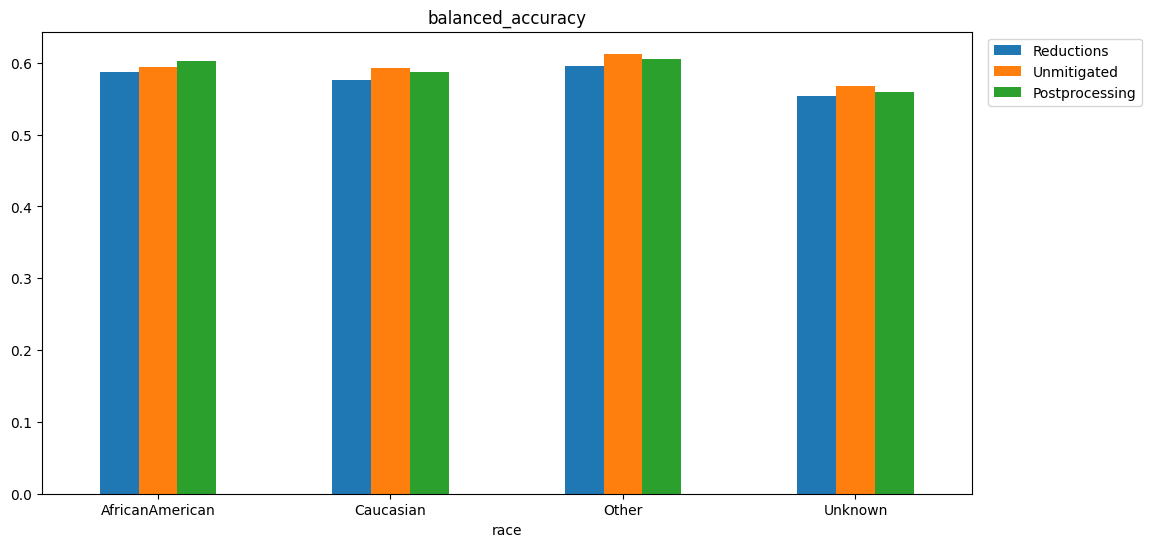

In [88]:
plot_technique_comparison(test_dict, "balanced_accuracy")

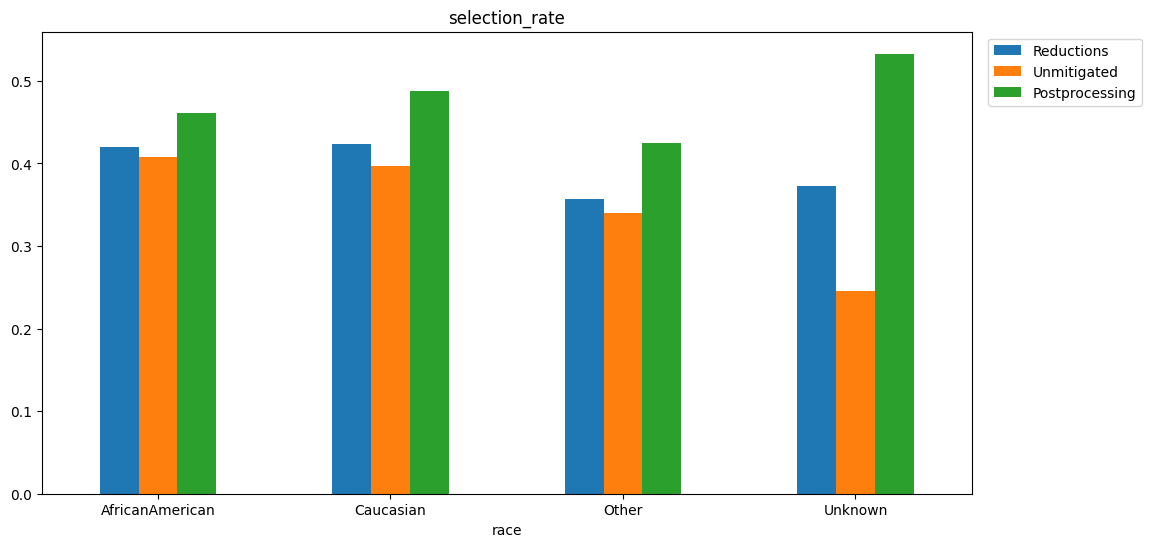

In [89]:
plot_technique_comparison(test_dict, "selection_rate")

**Model performance - overall**


In [90]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall,
    "Reductions": metricframe_reductions.overall
})
overall_df.T

,selection_rate,false_negative_rate,false_positive_rate,true_negative_rate,true_positive_rate,balanced_accuracy
Unmitigated,0.392870,0.440042,0.371878,0.628122,0.559958,0.594040
Postprocessing,0.480897,0.358338,0.460700,0.539300,0.641662,0.590481
Reductions,0.419461,0.441099,0.401942,0.598058,0.558901,0.578479


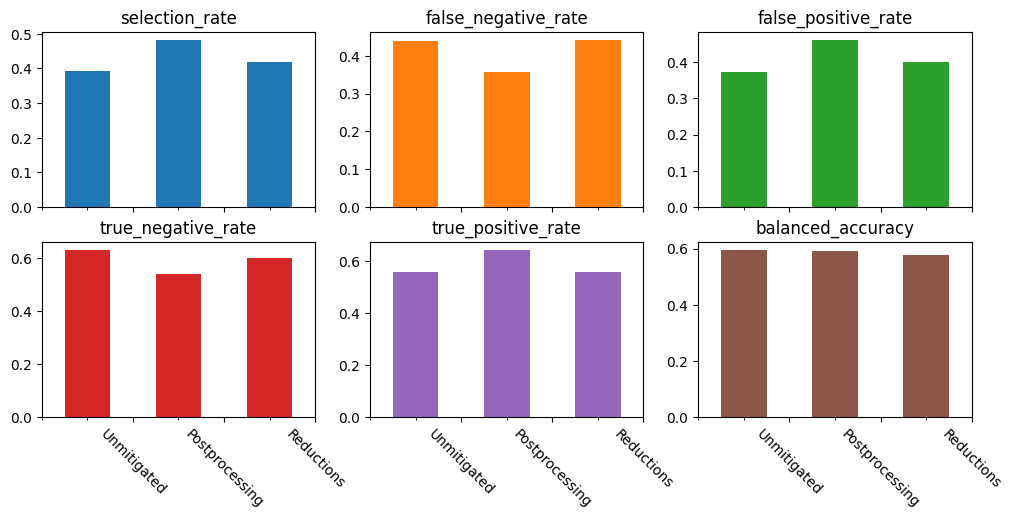

In [91]:
overall_df.transpose().plot.bar(subplots=True, layout= [2,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);


In [92]:
difference_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.difference(),
    "Postprocessing": metricframe_postprocess.difference(),
    "Reductions": metricframe_reductions.difference()
}
)
difference_df.T

,selection_rate,false_negative_rate,false_positive_rate,true_negative_rate,true_positive_rate,balanced_accuracy
Unmitigated,0.161755,0.205560,0.152652,0.152652,0.205560,0.044535
Postprocessing,0.108372,0.028488,0.119593,0.119593,0.028488,0.046939
Reductions,0.067530,0.103694,0.069905,0.069905,0.103694,0.042634


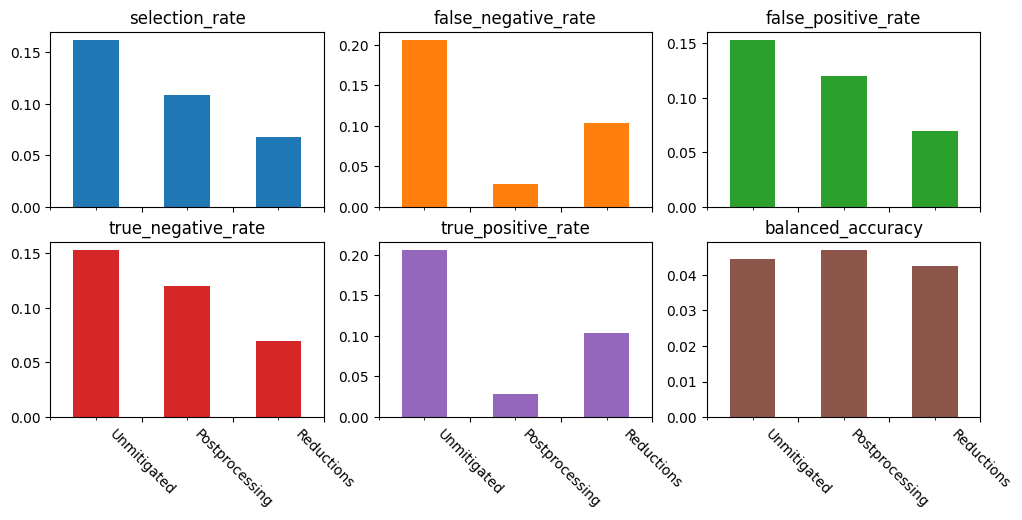

In [93]:
difference_df.T.plot.bar(subplots=True, layout= [2,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);



**Randomized predictions**

Both the ExponentiatedGradient and the ThresholdOptimizer produce random predictions, meaning they may give different results for the same input. However, in some cases, like legal restrictions, deploying a random model isn't possible. Here's how we handle this:

1. For the ThresholdOptimizer: We can make a deterministic predictor by setting fixed thresholds learned during optimization for each sensitive feature.

2. For the ExponentiatedGradient model: Instead of using the entire ExponentiatedGradient model, we can deploy one of its deterministic inner models, ensuring consistent predictions.

**Access to sensitive features**

The ThresholdOptimizer needs sensitive features during both training and deployment. If you can't access these features when the model's deployed, you can't use the ThresholdOptimizer. The ExponentiatedGradient model only needs sensitive features during training.

## Conclusion 

In this tutorial, we've looked closely at a healthcare scenario, covering everything from defining the task to evaluating the model, but we haven't reached the deployment stage yet. We've learned how fairness issues can pop up at every step, and we've used tools like datasheets for datasets, Fairlearn, and model cards to address them.

After deployment, it's important to keep an eye on key metrics to catch any performance differences and fairness concerns. As you learn more about how the model is used, you might need to tweak fairness metrics, update the model, or collect more data.

Remember, fairness isn't just a tech problem—it's a mix of technology, regulations, and organizational practices. 